# Plot creation notebook

This notebook will be utilized to create plots from the Tensorboard ouputs.
For instance, an interesting plot would be the average mean episodic reward and its standard deviation across different seeds for the different experiments.

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import tensorboard as tb
import pandas as pd
import numpy as np

## Utility Functions

goal_output should look like:

step | seed_1 | seed_2 | seed_3 | ... 
--- | --- | --- | --- | --- | 
... | ... | ... | ... | ... | 
500k |

In [2]:
def infer_value(run, index, df):
    value_at = lambda at: float(df[(df['run'] == run) & (df['step'] == at)]['value'])

    lt_step_nums = df[(df['run'] == run) & (df['step'] < index)]['step'].values
    ge_step_nums = df[(df['run'] == run) & (df['step'] >= index)]['step'].values

    # edge cases
    if len(lt_step_nums) == 0:
        # choose first value
        return value_at(ge_step_nums[0])
    elif len(ge_step_nums) == 0:
        # return last value
        return value_at(lt_step_nums[-1])
    else:
        li = lt_step_nums[-1]
        ri = ge_step_nums[0]
        lv = value_at(li)
        rv = value_at(ri)

    result = lv + (rv - lv)* (index - li) / (ri - li)
    return result

def plot_mean_std(
    exp_id: str,
    add_best = False,
    legend = True,
    n_best: int = 0,
    std_ddof: int = 0,
    save_path: str = None
):
    exp = tb.data.experimental.ExperimentFromDev(exp_id)
    df = exp.get_scalars()
    df = df[df['tag'] == "rollout/ep_rew_mean"]

    x_range = np.linspace(0, max(df['step']) + 1, max(df['step'])//750, dtype=int)
    d = {run : [infer_value(run, x, df) for x in x_range] for run in df['run'].unique()}
    d = pd.DataFrame(d)

    sns.set_theme()
    if n_best != 0:
        assert n_best > 0 and n_best < len(df['run'].unique())
        raise NotImplementedError()

    means = d.mean(axis=1).values
    stds = d.std(axis=1, ddof=std_ddof).values
    plt.plot(x_range, means, 'b-', label="mean episodic reward")
    plt.fill_between(x_range, means -  stds, means + stds, color="r", alpha=0.2)
    if add_best:
        run_i = np.argmax(d.values[-1])
        plt.plot(x_range, d[d.columns[run_i]], "g--", label="best run")
    if legend:
        plt.legend(loc='upper left')
    if save_path is not None:
        plt.savefig(save_path + ".pdf", format="pdf")

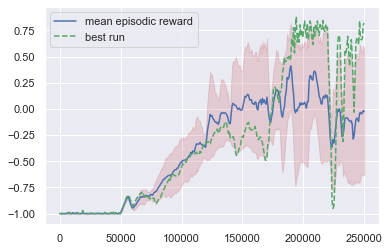

In [3]:
plot_mean_std("ly57jevlQXe42Q9sKmBYzQ", add_best=True)

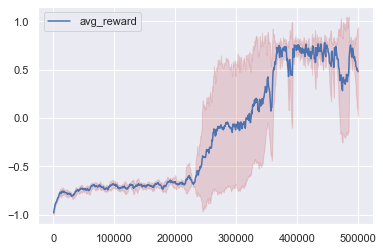

In [115]:
create_avg_std_plot(df, save_path="figures/a2c_success")